# Diffusion probabilistic models - Applications to waveforms

#### Author : Philippe Esling (esling@ircam.fr)

This third notebook continues the exploration of _diffusion probabilistic models_ [ [ 1 ] ](#ref1) in our four notebook series.
   1. Score matching and Langevin dynamics.
   2. Diffusion probabilistic models and denoising
   3. Applications to waveforms with WaveGrad
   4. Implicit models to accelerate inference

Here, we quickly recall the basics of _score matching_ [ [ 3 ] ](#ref3), _Langevin dynamics_ and diffusion probabilistic models [ [ 1 ] ](#ref2) seen in the previous notebooks, in order to discuss applications to waveform data, through the _WaveGrad_ model [ [ 5 ] ](#ref5)

## Theoretical bases - quick recap

In this section we provide a quick recap on **score matching** and **diffusion probabilistic models**, still based on the _swiss roll_ dataset.

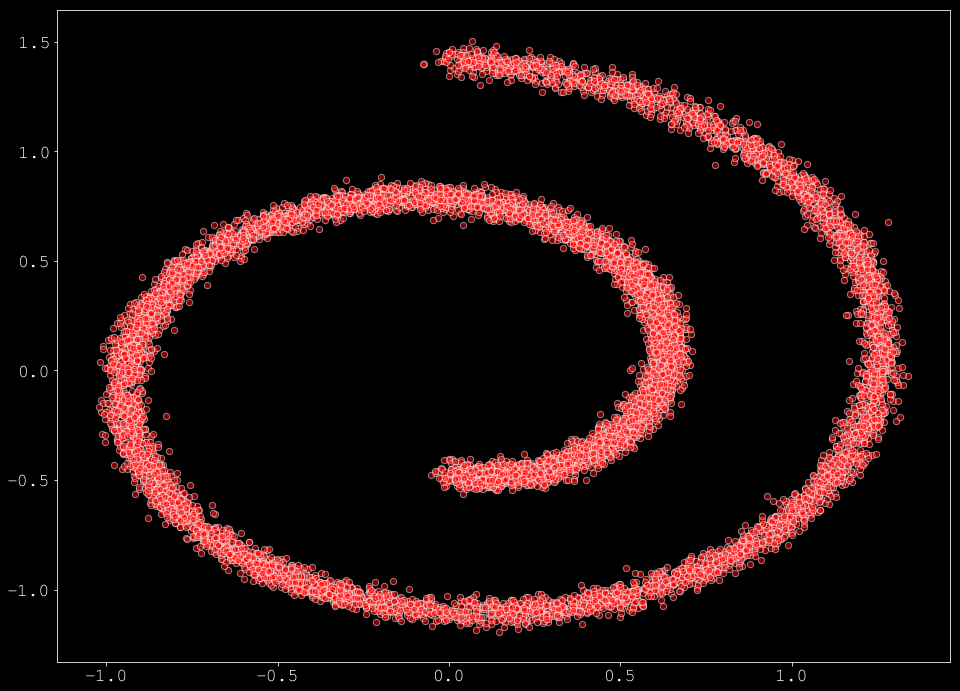

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
from helper_plot import hdr_plot_style
hdr_plot_style()
# Sample a batch from the swiss roll
def sample_batch(size, noise=0.3):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0
# Plot it
data = sample_batch(10**4).T
plt.figure(figsize=(16, 12))
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40);

### Score matching

_Score matching_ aims to learn the _gradients_ (termed _score_) of $\log p(\mathbf{x})$ with respect to $\mathbf{x}$ instead of directly $\log p(\mathbf{x})$. Therefore, we seek a model to approximate
$$
\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})
$$

Finding this approximation, we can use _Langevin dynamics_ to produce true samples from a density $p(\mathbf{x})$, by relying only on $\nabla_{\mathbf{x}} \log p(\mathbf{x})$

$$\mathbf{x}_{t + 1} = \mathbf{x}_t + \frac{\epsilon}{2} \nabla_{\mathbf{x}_t} log p(\mathbf{x}_t) + \sqrt{\epsilon} \mathbf{z}_{t}$$

where $\mathbf{z}_{t}\sim \mathcal{N}(\mathbf{0},\mathbf{I})$ and under $\epsilon \rightarrow 0, t \rightarrow \inf$: $\mathbf{x}_t$ converges to an exact sample from $p(\mathbf{x})$. Therefore, the key idea behind this _score-based generative modeling_ approach is that we can easily train a generative model, without defining any functional form on the distribution (no need to rely on an approximation, or to complexify a simple distribution).

#### Implementation

We have seen that optimizing $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})$ with an MSE objective was equivalent to optimizing

$$ \mathcal{L}_{matching} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right) + \frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]
, $$

where $\nabla_{\mathbf{x}} \mathcal{F}_{\theta}(\mathbf{x})$ denotes the Jacobian of $\mathcal{F}_{\theta}(\mathbf{x})$ with respect to $\mathbf{x}$. The complexity of computing this Jacobian can be removed in_denoising score matching_ objective [ [ 3 ] ](#ref3), by corrupting the inputs $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})$ and minimizing the following objective

$$ E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) - \nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) \right\lVert_2^2 \right]
, $$

As it has been shown in [ [ 3 ] ](#ref3),[ [ 8 ] ](#ref8), if we choose the noise distribution to be $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})=\mathcal{N}(\tilde{\mathbf{x}}\mid\mathbf{x}, \sigma^{2}\mathbf{I})$, then we have $\nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) = \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}}$. Therefore, the denoising score matching loss simply becomes

$$ \mathcal{l}(\theta;\sigma) = E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) +  \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}} \right\lVert_2^2 \right]
, $$

We can implement the _denoising score matching_ loss as follows

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
def denoising_score_matching(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)
    return loss

Regarding optimization, we can perform a very simple implementation of this process, by defining $\mathcal{F}_{\theta}(\mathbf{x})$ as being any type of neural network. We can perform a minimalistic implementation and observe that our model has learned to represent $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_x \log p(x)$ by plotting the output value across the input space

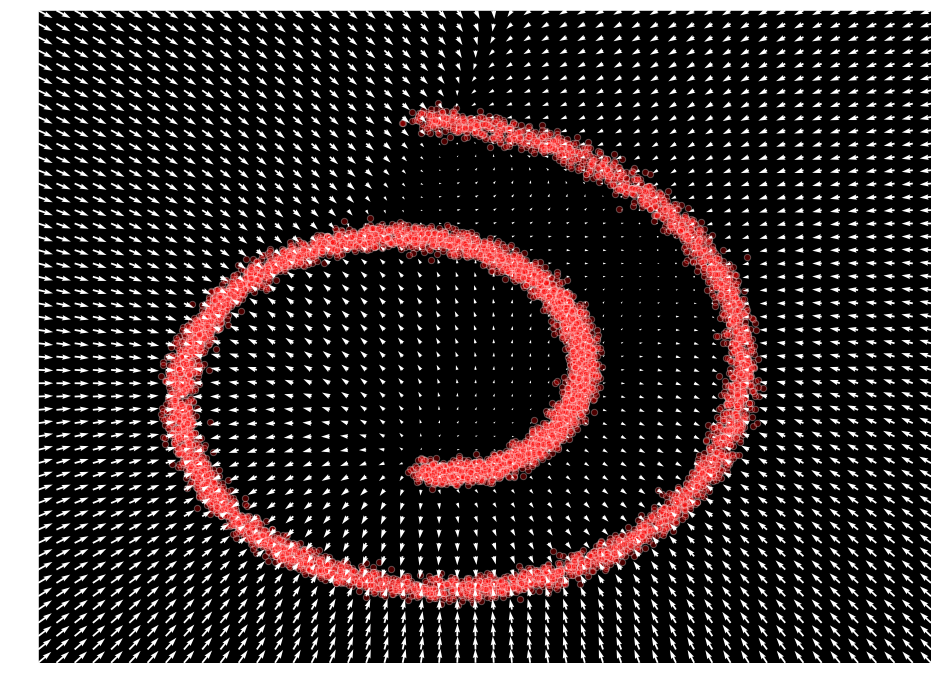

In [8]:
# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2))
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
for t in range(5000):
    # Compute the loss.
    loss = denoising_score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
    scores = model(torch.from_numpy(xx).float()).detach()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    plt.figure(figsize=(16,12))
    if (plot_scatter):
        plt.scatter(*data, alpha=0.3, color='red', edgecolor='white', s=40)
    plt.quiver(xx.T[0], xx.T[1], scores_log1p[:,0], scores_log1p[:,1], width=0.002, color='white')
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)
plot_gradients(model, data)

### Sampling

Based on our trained model $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_x \log p(x)$, and using _Langevin dynamics_, we can produce true samples from a density $p(\mathbf{x})$, by relying only on $\nabla_{\mathbf{x}} \log p(\mathbf{x})$, as shown in the following snippet

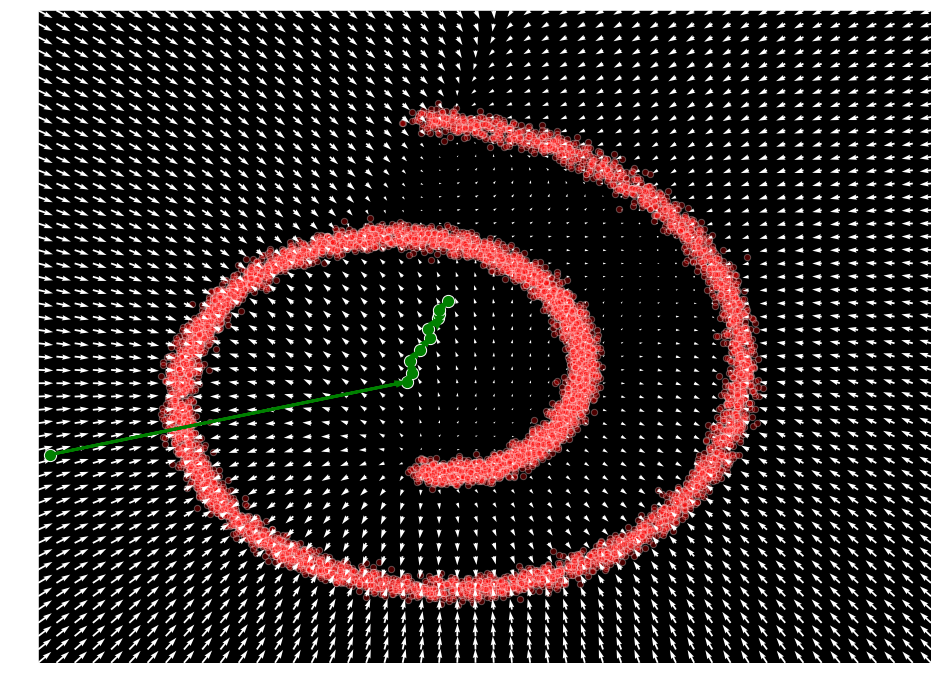

In [9]:
def sample_langevin(model, x=None, n_steps=10, eps=5e-3, decay=.9, temperature=1.0):
    if (x is None):
        x = torch.randn(2)
    x_sequence = [x.unsqueeze(0)]
    for s in range(n_steps):
        z_t = torch.rand(x.size())
        x = x + (eps / 2) * model(x) + (np.sqrt(eps) * temperature * z_t)
        x_sequence.append(x.unsqueeze(0))
        eps *= decay
    return torch.cat(x_sequence)
def plot_langevin():
    samples = sample_langevin(model).detach()
    plot_gradients(model, data)
    plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=150)
    # draw arrows for each mcmc step
    deltas = (samples[1:] - samples[:-1])
    deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
    for i, arrow in enumerate(deltas):
        plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="green", linewidth=3)
plot_langevin()

## Diffusion probabilistic models

_Diffusion probabilistic models_ [ [ 1 ] ](#ref1) are based on on a series of latent variables $ \mathbf{x}_{1},\cdots,\mathbf{x}_{T}$ that have the same dimensionality as a given input data, which is labeled as $\mathbf{x}_{0} \sim q(\mathbf{x}_{0})$. It models two reciprocal processes as Markov chains of these random variables. One (fixed) process $q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})$ gradually adds noise to the input data (the _diffusion_ or _forward_ process), destroying the signal up to full noise. Oppositely, the _reverse_ (parametric) process $p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})$ must learn how to _denoise local perturbations_ in order to invert this diffusion process (transform random noise into a high-quality waveform). Hence, learning involves estimating a _large number of small perturbations_, which is more tractable than trying to directly estimate the full distribution with a single potential function, as examplified in the following figure

<img src="images/diffusion.png" width="100%"/>

Therefore, we need to define the behavior of the two process, and train the _reverse_ process (modeled as conditional Gaussians) using variational inference, which allow for neural network parameterization and tractable estimation.

$$
\text{forward (diffusion)} : q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})
$$
$$
\text{reverse (parametric)} : p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})
$$

#### Forward process

In the forward process, the data distribution $q(\mathbf{x}_{0})$ is gradually converted into an analytically tractable distribution $\pi(\mathbf{y})$, by repeated application of a diffusion kernel, so that the complete distribution $q(\mathbf{x}_{0:T})$ (called _diffusion_ process) is defined as

$$
q(\mathbf{x}_{0:T}) =  q(\mathbf{x}_{0}) \prod_{t=1}^{T} q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})
$$

This diffusion kernel $q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})$ is set to gradually inject Gaussian noise, with a fixed variance schedule $\beta_{1},\cdots,\beta_{T}$ such that

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{1-\beta_{t}}\mathbf{x}_{t-1},\beta_{t}\mathbf{I})
$$

One important property of this forward process noted by Ho et al. [ [ 1 ] ](#ref1) is that we can perform sampling at any arbitrary timestep $t$, such that

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{0}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0},(1-\bar{\alpha}_{t})\mathbf{I}),
$$

where $\alpha_{t}=1-\beta_{t}$ and $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$. Therefore, we can create a very efficient diffusion sampling function. Note that this depends on the given variance schedule of $\beta_{1},\cdots,\beta_{T}$ that we compute prior to the function.


#### Implementing the forward process
This allows to perform a very efficient implementation of the forward process, where we can directly sample at any given timesteps, as shown in the following code.

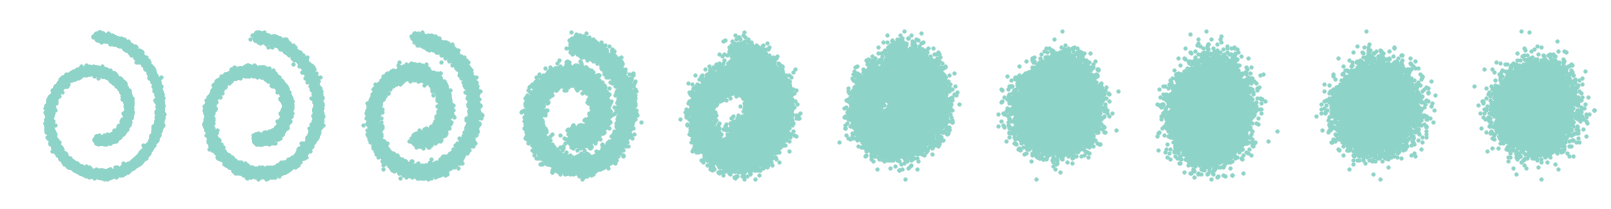

In [10]:
n_steps = 100
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)
# Create schedule
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)
# Fixed computation of variables for all timesteps
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
# Sampling function
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)
def plot_diffusion():
    fig, axs = plt.subplots(1, 10, figsize=(28, 3))
    for i in range(10):
        q_i = q_sample(dataset, torch.tensor([i * 10]))
        axs[i].scatter(q_i[:, 0], q_i[:, 1], s=10);
        axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')
plot_diffusion()

#### Reverse process

The generative distribution that we aim to learn will be trained to perform the _reverse_ trajectory, starting from Gaussian noise to gradually remove local perturbations. Therefore the reverse process starts with our given tractable distribution $p(\mathbf{x}_{T})=\pi(\mathbf{x}_{T})$ and is described as

$$
p_{\theta}(\mathbf{x}_{0:T}) =  p(\mathbf{x}_{T}) \prod_{t=1}^{T} p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})
$$

Each of the transitions in this process can simply be defined as conditional Gaussians (**note**: which is reminiscent of the definition of VAEs). Therefore, during learning, only the mean and covariancce for a Gaussian diffusion kernel needs to be trained

$$
p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}) = \mathcal{N}(\mathbf{x}_{t-1} ; \mathbf{\mu}_{\theta}(\mathbf{x}_{t},t),\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t))
$$

The two functions defining the mean $\mathbf{\mu}_{\theta}(\mathbf{x}_{t},t)$ and covariance $\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t)$ can be parametrized by deep neural networks. Note also that these functions are parametrized by $t$, which means that a single model can be used for all time steps.

Here, we show a naive implementation of this process, where we have a given `model` to infer variance. Note that this model is _shared across all time steps_ but conditionned on that said time step.

In [11]:
import torch.nn.functional as F
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 4)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)
model = ConditionalModel(n_steps)
    
def p_mean_variance(model, x, t):
    # Go through model
    out = model(x, t)
    # Extract the mean and variance
    mean, log_var = torch.split(out, 2, dim=-1)
    var = torch.exp(log_var)
    return mean, log_var

As we can see, the reverse process consists in inferring the values of the mean and log variance for a given timestep, by providing both the sample $\mathbf{x}_{t}$ at a given time step, and that time step $t$ that we can use to condition the models for $\mathbf{\mu}_{\theta}(\mathbf{x}_{t},t)$ and $\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t)$. Finally, obtaining samples from the model is given by running through the whole Markov chain in reverse, starting from a normal distribution to obtain samples from the target distribution. Note that this process can be very slow if we have a large number of steps, as we need to wait for a given $\mathbf{x}_{t}$ to infer the following $\mathbf{x}_{t-1}$

In [12]:
def p_sample(model, x, t):
    mean, log_var = p_mean_variance(model, x, torch.tensor(t))
    noise = torch.randn_like(x)
    shape = [x.shape[0]] + [1] * (x.ndimension() - 1)
    nonzero_mask = (1 - (t == 0))
    sample = mean + torch.exp(0.5 * log_var) * noise
    return (sample) 
def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

### Training

By using Jensen's inequality on the previous expression, we can see that the training may be performed by optimizing the variational bound on negative log-likelihood

\begin{align}
\mathbb{E}\left[-\log p_{\theta}(\mathbf{x}_{0}) \right] & \leq \mathbb{E}_{q}\left[-\log \frac{p_{\theta}(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_{0})} \right] \\
\mathcal{L} & = \mathbb{E}_{q}\left[ -\log p(\mathbf{x}_{T}) - \sum_{t\geq 1} \log \frac{p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})}{q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})} \right]
\end{align}

Therefore, efficient training is allowed by optimizing random terms of $\mathcal{L}$ with gradient descent.

Further improvements, proposed by Ho et al. [ [ 1 ] ](#ref1), come from variance reduction by rewriting $\mathcal{L}$ as a sum of KL divergences

\begin{align}
\mathcal{L} &= \mathbb{E}_{q}\left[ \mathcal{L}_{T} + \sum_{t>1} \mathcal{L}_{t-1} + \mathcal{L}_{0} \right] \\
\mathcal{L}_{T} &= D_{KL}(q(\mathbf{x}_{T}\mid\mathbf{x}_{0}) \Vert p(\mathbf{x}_{T})) \\
\mathcal{L}_{t-1} &= D_{KL}(q(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{x}_{0}) \Vert p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})) \\
\mathcal{L}_{0} &= - \log p_{\theta}(\mathbf{x}_{0}\mid\mathbf{x}_{1}) 
\end{align}

All the KL divergences defined in this equation compare Gaussians, which means that they have a closed-form solution.

In [13]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl
def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(torch.tensor(np.sqrt(2.0 / np.pi)) * (x + 0.044715 * torch.pow(x, 3))))
def discretized_gaussian_log_likelihood(x, means, log_scales):
    # Assumes data is integers [0, 255] rescaled to [-1, 1]
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(torch.clamp(cdf_plus, min=1e-12))
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - cdf_min, min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(x < -0.999, log_cdf_plus, torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(torch.clamp(cdf_delta, min=1e-12))))
    return log_probs

### Implementing the loss - random time steps

To optimize this loss, we will need several computational tools, notably the KL divergence between two gaussians, and the entropy of a Gaussian.

The way that the model is trained is slightly counterintuitive, since we select a timestep at random to train for each of the batch input. The implementation taken from the [DDIM repo](https://github.com/ermongroup/ddim) provides a form of _antithetic sampling_, which allows to ensure that symmetrical points in the different chains are trained jointly. Therefore, the final procedure consists in first run the forward process on each input at a given (random) time steps (performing diffusion). Then we run the reverse process on this sample, and compute the loss.

In [14]:
def loss_variational(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # Perform diffusion for step t
    x_t = q_sample(x_0, t)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the KL loss
    kl = normal_kl(true_mean, true_var, model_mean, model_var)
    kl = torch.mean(kl.view(batch_size, -1), dim=1) / np.log(2.)
    # NLL of the decoder
    decoder_nll = -discretized_gaussian_log_likelihood(x_0, means=model_mean, log_scales=0.5 * model_var)
    decoder_nll = torch.mean(decoder_nll.view(batch_size, -1), dim=1) / np.log(2.)
    # At the first timestep return the decoder NLL, otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
    output = torch.where(t == 0, decoder_nll, kl)
    return output.mean(-1)

## Denoising diffusion probabilistic models (DDPM)

Ho et al. [ [ 1 ] ](#ref1) largely enhanced this _diffusion models_ idea, by first proposing to rely on a new parameterization for the mean function
$$
\mathbf{\mu}_{\theta}(\mathbf{x}_{t}, t) = \frac{1}{\sqrt{\alpha_{t}}} \left( (\mathbf{x}_{t} - \frac{\beta_{t}}{\sqrt{1 - \bar{\alpha}}_{t}} \mathbf{\epsilon}_{\theta} (\mathbf{x}_{t}, t) \right) 
$$

Note that now, the model is trained at directly estimating a form of **_conditional noise_ function**, which is used in the training and sampling process. Furthermore, the authors suggest to use a fixed variance function

$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}
$$

This leads to a new sampling procedure for the reverse process as follows (we also quickly redefine the model to output the correct dimensionality).

In [22]:
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)
    
def p_sample(model, x, t):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

### Simplifying loss to denoising score matching

Based on this new parameterization [ [ 1 ] ](#ref1) for the mean of the reverse process
$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1 - \alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}
$$
The training objective can simplify to
$$
\mathcal{L}_{t-1}-C = \mathbb{E}_{\mathbf{x}_{0},\mathbf{\epsilon}}\left[ \frac{\beta_{t}^{2}}{2\sigma_{t}^{2}\alpha_{t}(1-\bar{\alpha}_{t})} \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right]
$$
which resembles denoising score matching over multiple noise scales indexed by $t$.

#### Simplified training objective

The authors proposed to largely simplify the objective, by dropping the initial factor 
$$
\mathcal{L}_{\text{simple}}=\mathbb{E}_{t, \mathbf{x}_{0},\mathbf{\epsilon}}\left[ \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right]
$$
They state that this variant is beneficial to the sample quality.

In [23]:
def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()

#### Stabilizing training with Exponential Moving Average (EMA)

This idea is found in most of the implementations, which allows to implement a form of _model momentum_. Instead of directly updating the weights of the model, we keep a copy of the previous values of the weights, and then update a weighted mean between the previous and new version of the weights. Here, we reuse the implementation proposed in the [DDIM repository](https://github.com/ermongroup/ddim).

In [24]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

The training loop is finally obtained with the following code

tensor(1.1481, grad_fn=<MeanBackward0>)
tensor(0.6328, grad_fn=<MeanBackward0>)
tensor(0.6844, grad_fn=<MeanBackward0>)
tensor(0.8178, grad_fn=<MeanBackward0>)
tensor(1.1822, grad_fn=<MeanBackward0>)
tensor(0.8505, grad_fn=<MeanBackward0>)
tensor(0.5113, grad_fn=<MeanBackward0>)
tensor(0.5796, grad_fn=<MeanBackward0>)
tensor(0.5429, grad_fn=<MeanBackward0>)
tensor(0.7098, grad_fn=<MeanBackward0>)
tensor(0.6296, grad_fn=<MeanBackward0>)


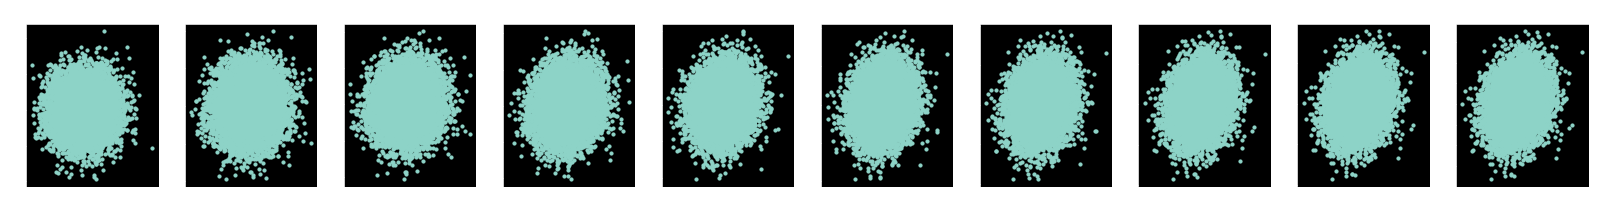

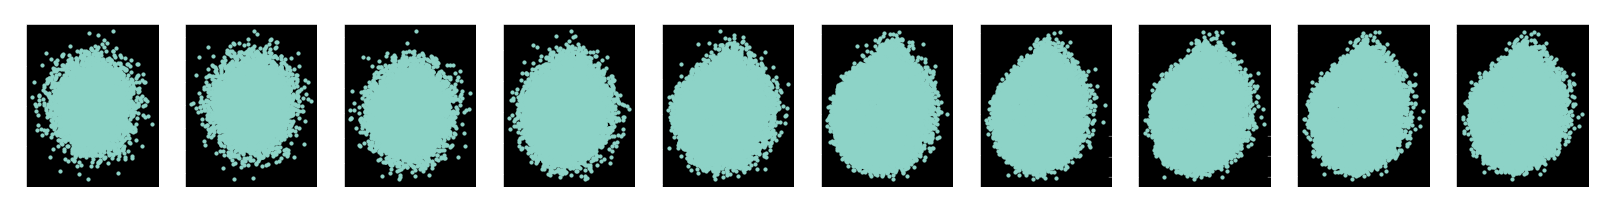

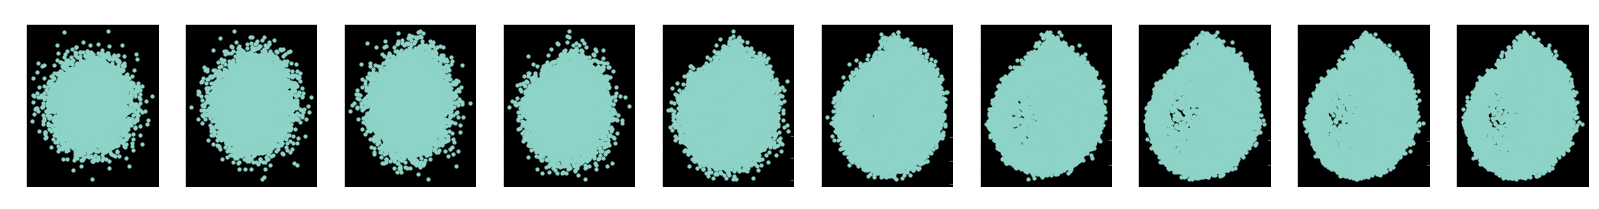

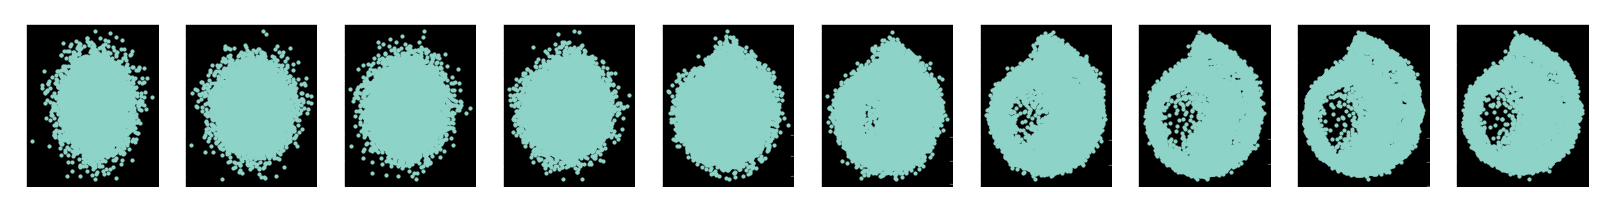

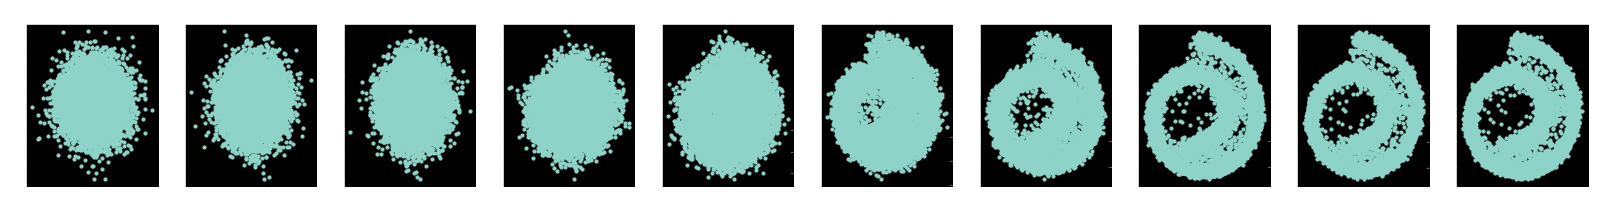

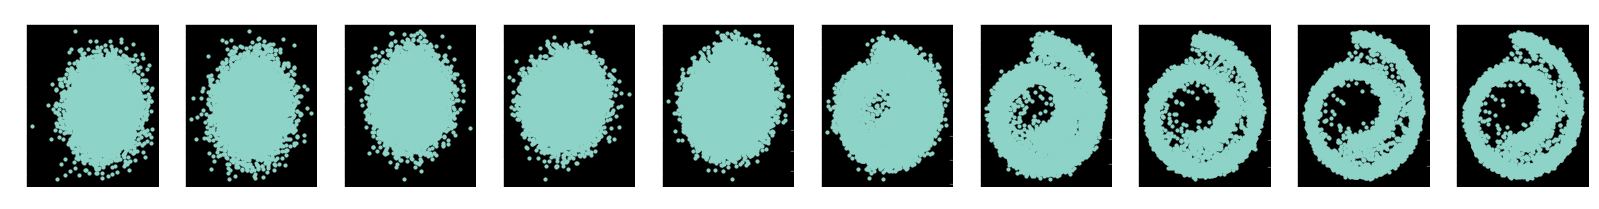

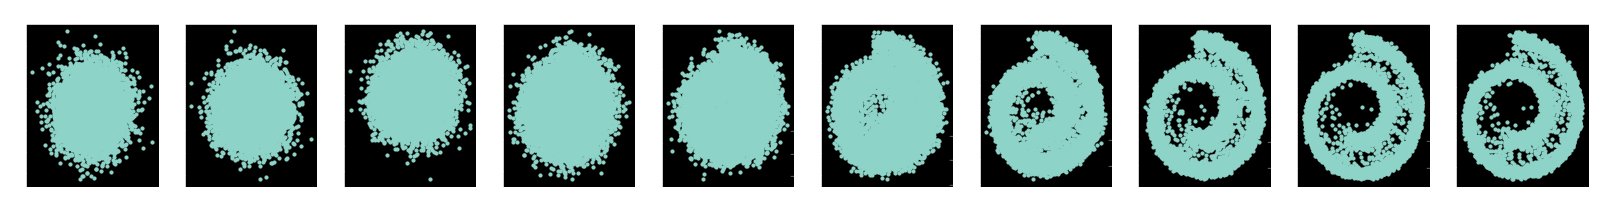

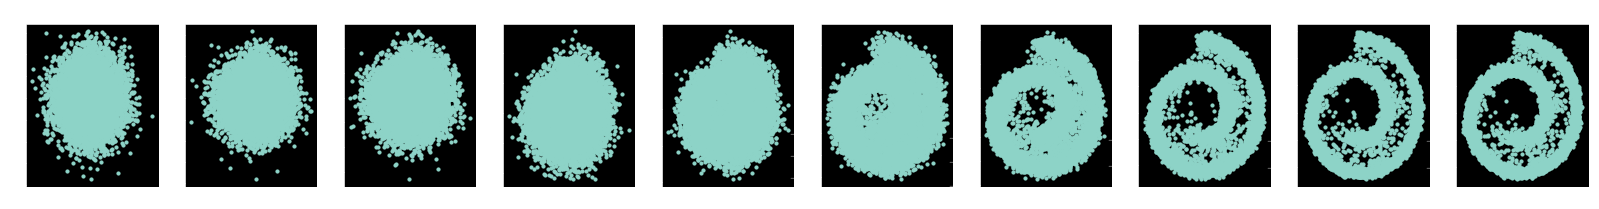

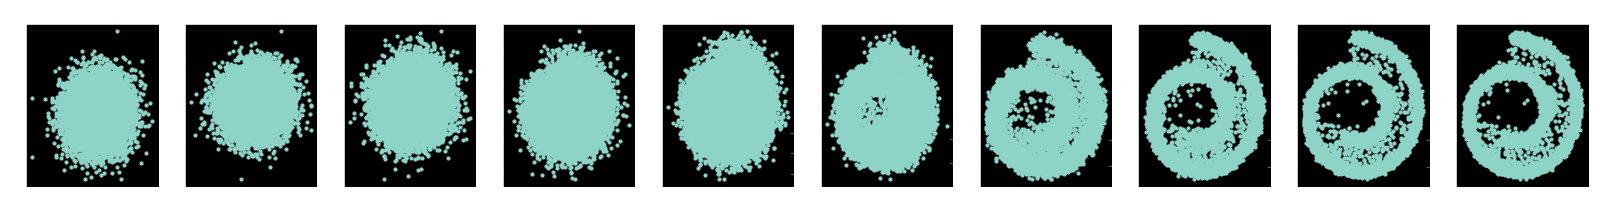

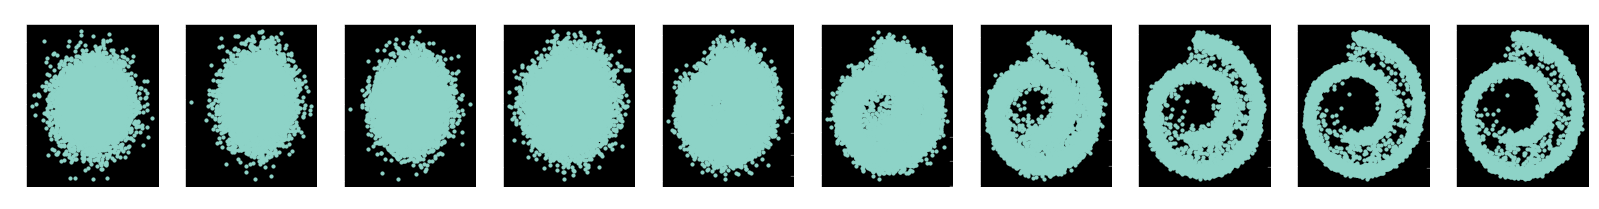

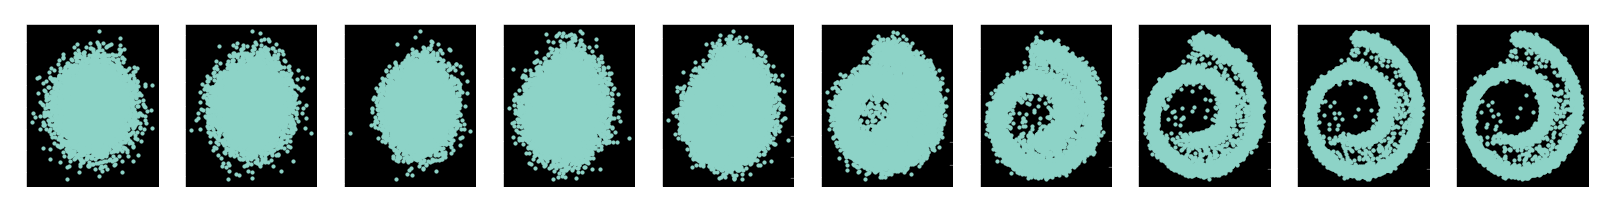

In [26]:
model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 128
for t in range(2001):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 200 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
            #axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

## WaveGrad - Applications to waveform generation

Recently, these ideas from _score matching_ and _diffusion models_ were applied to waveform generation, through a model called _WaveGrad_ [ [ 5 ] ](#ref5). This model proposes a conditional architecture to perform estimation of the gradients of the data log-density. The paper follows almost exactly the training of Ho et al. [ [ 1 ] ](#ref1), but provides some tricks to ensure the quality of waveform generation.

### Toy waveform dataset

In order to study this model, we will work with a toy dataset of simple waveforms. To do so, we generate a set of random additive sounds as defined in the following function.

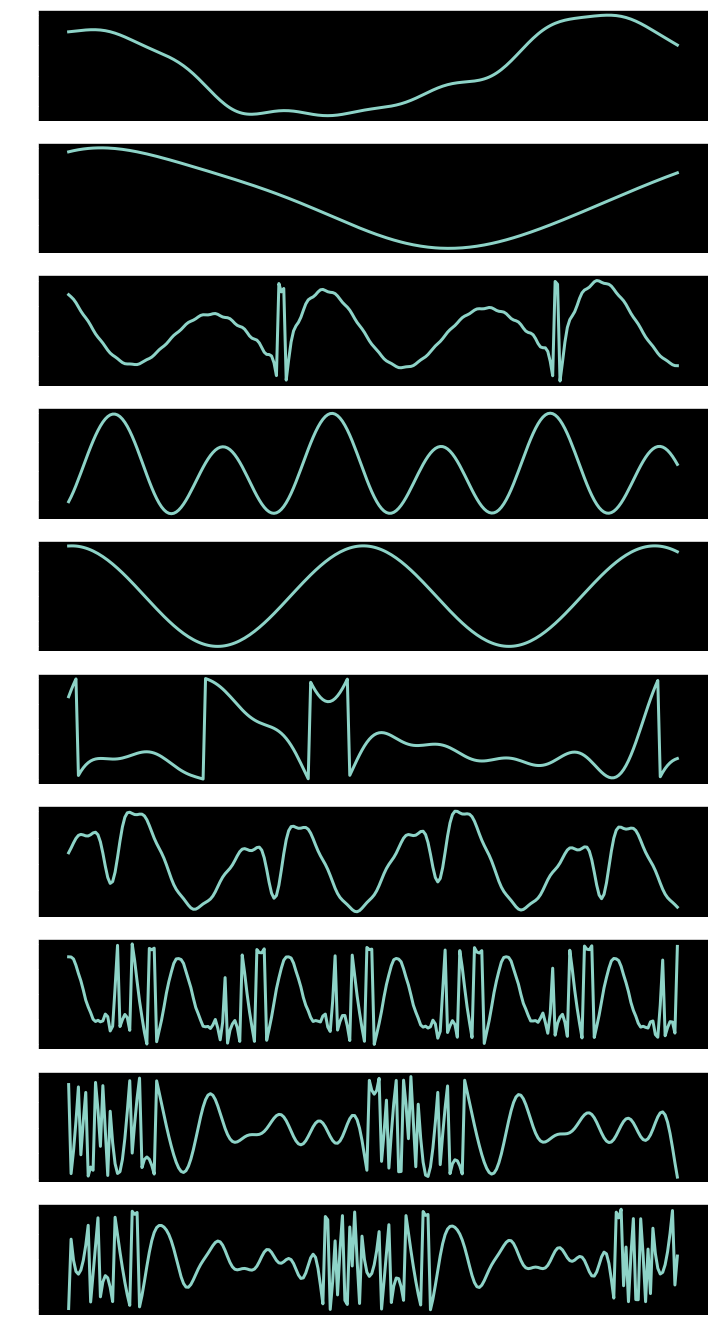

In [38]:
import pyo
import librosa
# General settings
midi_range = [40, 60]
def start_pyo_server():
    # Server parameters
    sr = 22050
    channels = 1
    # Start server
    s = pyo.Server(audio="offline")
    # set server parameters
    s.setSamplingRate(sr)
    s.setNchnls(channels)
    s.setVerbosity(1)
    s.boot()
    return s
def generate_additive_set(n_samples=1e5, duration = 0.075, slice_id = [250, 1250]):
    """
    Dataset 2 - Additive synthesis with BiQuad filter:
    1. Harmonicity = sum(s3.bn/in((2n+j)*f*i), j = [0,1,0.1]
    2. # Partials k
    3. Filter (Q)
    4. Filter (f)
    """
    # Server settings
    s = start_pyo_server()
    fformat = 'WAVE'
    sampletype = 0  
    # Subroutine to generate one sound
    def generate_additive_sound():
        # Randomly sample parameters
        f0 = librosa.midi_to_hz(np.random.randint(midi_range[0], midi_range[1]))
        freq_ar = [f0]
        # Number of harmonics
        n_harm = np.arange(0, 20, 1)[np.random.randint(0, 20)]
        # Inharmonicity factor
        inharm = np.arange(0, 0.1, 0.001)[np.random.randint(0, 100)]
        for k in range(n_harm):
            freq_new = (2 * (k + 1)) * f0
            freq_ar.append(freq_new)
        # Filter resonance
        Q = np.arange(1, 11, 1)[np.random.randint(0, 10)]
        # Filter frequency
        filter_f = np.arange(1, 11, 1)[np.random.randint(0, 10)]
        # Set recording
        s.recordOptions(dur=duration, filename="/tmp/gen.wav", fileformat=fformat, sampletype=sampletype)
        # Create sound
        sin_sig = pyo.Sine(freq=freq_ar, mul=1)
        # Filter with biquad
        sig_filtered = pyo.Biquad(sin_sig, freq=float(filter_f * 22050 / (2 * 100)), q=float(Q), type=2).out()
        # start the render
        s.start()
        # cleanup
        s.recstop()
    # Generate dataset
    dataset = []
    for s_id in range(int(n_samples)):
        generate_additive_sound()
        y, sr = librosa.load('/tmp/gen.wav')
        if (slice_id is not None):
            y = y[slice_id[0]:slice_id[1]]
        y = y / np.max(y)
        dataset.append(y)
    s.shutdown()
    return dataset    
dataset = generate_additive_set(1e3, slice_id = [250, 500])
plt.figure(figsize=(12, 24))
for i in range(10):
    plt.subplot(10, 1, i+1)
    plt.plot(dataset[i])
dataset = torch.tensor(dataset)

## WaveGrad model

The WaveGrad model is highly inspired by the DDPM model, but introduces several specificities for training on audio data. First, note that the model is trained to reconstruct a waveform by conditioning on the Mel spectrogram. Hence, this introduces an external _conditioning_ signal , which makes WaveGrad an approach applied to learning _conditional_ generative models of the form $p(\mathbf{y}\vert\mathbf{x})$. The other major differences introduced by WaveGrad are
1. Conditioning on the continuous noise level ($\beta_{t}$), rather than the timestep index ($t$)
2. Fine-tuning the noise schedule ($\beta_{1},\cdots,\beta_{T}$), depending on the number of steps ($T$)
3. Using a hierarchical sampling scheme on the continuous noise level ($\sqrt{\bar{\alpha}}$)
4. Introducing a specific architecture for waveform generation
    - Using positional encoding (from Transformers)
    - Relying on downsampling and upsampling blocks
    - Using FiLM layers to condition on Mel spectrogram

### Introducing a conditional model

Compared to the formulation of DDPM, WaveGrad is defined as a conditional model. This implies that the full model probability is defined as

$$
p_{\theta}(\mathbf{x}_{0}\vert \mathbf{y}) = \int p_{\theta}(\mathbf{x}_{0:T}\vert\mathbf{y})d\mathbf{x}_{1:T}
$$

where $\mathbf{y}$ is the set of conditioning features (for instance a Mel spectrogram). The forward (_diffusion_) process remains unchanged, but the reverse (trained) process becomes a condtional definition with

$$
p_{\theta}(\mathbf{x}_{0:T}\vert\mathbf{y}) =  p(\mathbf{x}_{T}\vert\mathbf{y}) \prod_{t=1}^{T} p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{y})
$$

Each of the transitions in this process are still conditional Gaussians, but this time including an extra set of conditioning signal through $\mathbf{y}$. During learning, we still aim to train the mean and covariance for a Gaussian diffusion kernel

$$
p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{y}) = \mathcal{N}(\mathbf{x}_{t-1} ; \mathbf{\mu}_{\theta}(\mathbf{x}_{t},t,\mathbf{y}),\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t,\mathbf{y}))
$$

Note that in this notebook implementation, we try to _avoid using conditioning features_ and rather aim to directly model the waveform.

### Hierarchical sampling scheme - continuous noise level

Similarily to DDPM, the WaveGrad model is trained to infer the noise function, depending on the timestep in the Markov cahin. However, compared to DDPM, the model is now conditioned on the _continuous noise level_ $\sqrt{\bar{\alpha_{t}}}$ instead of the timestep $t$ (and also the extraneous features $\mathbf{y}$). To do so, the model introduces a _hierarchical sampling scheme_, where we first sample the time step $t$ as
$$
t\sim\mathcal{U}(\{1,\cdots,T\})
$$
Then, the noise level $\sqrt{\bar{\alpha}}$ is also continuously sampled from a uniform function such that 
$$
\sqrt{\bar{\alpha}} \sim \mathcal{U}(\sqrt{\bar{\alpha}_{t-1}},\sqrt{\bar{\alpha}_{t-1}}),
$$
where $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$ and $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$ where $\beta_{i}$ is a predefined noise schedule (similarly to the original diffusion model definitions).

In [76]:
alphas_prod_p_sqrt = alphas_prod_p.sqrt()
def sample_continuous_noise_level(batch_size):
    """
    Samples continuous noise level.
    This is what makes WaveGrad different from other Denoising Diffusion Probabilistic Models.
    """
    t = np.random.choice(range(1, n_steps), size=batch_size)
    continuous_sqrt_alpha_cumprod = torch.FloatTensor(
        np.random.uniform(
            alphas_prod_p_sqrt[t-1],
            alphas_prod_p_sqrt[t],
            size=batch_size
        ))
    return continuous_sqrt_alpha_cumprod.unsqueeze(-1)

Therefore, we have to update the sampling function for the forward process, in order to account for this continuous noise sampling scheme.

In [77]:
def q_sample(x_0, continuous_sqrt_alpha_cumprod=None, eps=None):
    batch_size = x_0.shape[0]
    if isinstance(eps, type(None)):
        continuous_sqrt_alpha_cumprod = sample_continuous_noise_level(batch_size)
        eps = torch.randn_like(x_0)
    # Closed form signal diffusion
    outputs = continuous_sqrt_alpha_cumprod * x_0 + (1 - continuous_sqrt_alpha_cumprod**2).sqrt() * eps
    return outputs

def q_posterior(x_start, x, t):
    """ Computes reverse (denoising) process posterior q(y_{t-1}|y_0, y_t, x) """
    posterior_mean = posterior_mean_coef_1[t] * x_start + posterior_mean_coef_2[t] * x
    posterior_log_variance_clip = posterior_log_variance_clipped[t]
    return posterior_mean, posterior_log_variance_clip

### Impact on the sampling function

ALthough the noise is continuously sampled in the _training_ phase, note that there is no major changes in the sampling (inference) phase. However, we have to update the sampling function as we now need to use the model on a continuous noise level $\sqrt{\bar{\alpha}_{t}}$ rather than the discrete timestep $t$. Note that we also clip the output of the model, so that the sample is contained inside $[-1, 1]$.

In [78]:
n_steps = 50
betas = make_beta_schedule(schedule='linear', n_timesteps=n_steps, start=1e-6, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_prod_p_sqrt = alphas_prod_p.sqrt()
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
sqrt_recip_alphas_cumprod = (1 / alphas_prod).sqrt()
sqrt_alphas_cumprod_m1 = (1 - alphas_prod).sqrt() * sqrt_recip_alphas_cumprod
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

In [79]:
def predict_start_from_noise(x, t, eps):
    """ Computes y_0 from given y_t and reconstructed noise. """
    return sqrt_recip_alphas_cumprod[t] * x - sqrt_alphas_cumprod_m1[t] * eps

def p_mean_variance(model, x, t, clip_denoised=True):
    """ Computes Gaussian transitions of Markov chain at step t """
    batch_size = x.shape[0]
    noise_level = torch.FloatTensor([alphas_prod_p_sqrt[t+1]]).repeat(batch_size, 1)
    # Infer noise, conditioned on continuous level
    eps_recon = model(x, noise_level)
    x_recon = predict_start_from_noise(x, t, eps_recon)
    # Output clipping in WaveGrad
    if clip_denoised:
        x_recon.clamp_(-1.0, 1.0)
    model_mean, posterior_log_variance = q_posterior(x_recon, x, t)
    return model_mean, posterior_log_variance
    
def p_sample(model, x, t):
    model_mean, model_log_variance = p_mean_variance(model, x, t)
    eps = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
    return model_mean + eps * (0.5 * model_log_variance).exp()

def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps - 1)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

### Loss function

Similarily to DDPM, the WaveGrad model trains on a loss very similar to the denoising score matching objective. This implies that the model tries to infer a form of noise function. However, compared to DDPM, the model is now conditioned on the _continuous noise level_ $\sqrt{\bar{\alpha_{t}}}$ instead of the timestep $t$, and also the extraneous features $\mathbf{y}$. The authors also found that training with the $L_{1}$ loss instead of the $L_{2}$ provides a higher quality of samples. This leads to the following loss

$$
\mathcal{L}_{\text{simple}}=\mathbb{E}_{t, \mathbf{x}_{0},\mathbf{\epsilon}}\left[ \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, \mathbf{y}, \sqrt{\bar{\alpha}}) \Vert_{1} \right],
$$

Hence, the implementation is almost identical to that of DDPM, with the continuously sampled noise $\sqrt{\bar{\alpha}}$ and the L1 loss, as shown in the following code

In [80]:
def compute_loss(model, x_0):
    # Sample continuous noise level
    batch_size = x_0.shape[0]
    continuous_sqrt_alpha_cumprod = sample_continuous_noise_level(batch_size)
    eps = torch.randn_like(x_0)
    # Diffuse the signal
    y_noisy = q_sample(x_0, continuous_sqrt_alpha_cumprod, eps)
    # Reconstruct the added noise
    eps_recon = model(y_noisy, continuous_sqrt_alpha_cumprod)
    loss = torch.nn.L1Loss()(eps_recon, eps)
    return loss

### Model architecture

Regarding model architecture, WaveGrad proposes to use several existing mechanisms from the literature in order to solve different parts of the model.
- Using positional encoding (from Transformers)
- Relying on downsampling and upsampling blocks
- Using FiLM layers to condition on Mel spectrogram

As a first approach, we only change the previous model to include the _positional encoding_, and also add some simple _conditional 1-dimensional convolution_. This allows to test the overall approach with a simple model wore adapted to waveform data.

In [81]:
class PositionalEncoding(nn.Module):
    def __init__(self, n_channels):
        super(PositionalEncoding, self).__init__()
        self.n_channels = n_channels
        self.linear_scale = 5e3

    def forward(self, noise_level):
        if len(noise_level.shape) > 1:
            noise_level = noise_level.squeeze(-1)
        half_dim = self.n_channels // 2
        exponents = torch.arange(half_dim, dtype=torch.float32).to(noise_level) / float(half_dim)
        exponents = 1e-4 ** exponents
        exponents = self.linear_scale * noise_level.unsqueeze(1) * exponents.unsqueeze(0)
        return torch.cat([exponents.sin(), exponents.cos()], dim=-1)   
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)

    def forward(self, x, y):
        out = self.lin(x)
        gamma = y
        out = gamma * out
        return out
class ConditionalConv1d(nn.Module):
    def __init__(self, **kwargs):
        super(ConditionalConv1d, self).__init__()
        self.conv1d = torch.nn.Conv1d(**kwargs)
        self.embedding = PositionalEncoding(kwargs.get('out_channels'))
        torch.nn.init.orthogonal_(self.conv1d.weight.data, gain=1)

    def forward(self, x, y):
        out = self.conv1d(x);
        gamma = self.embedding(y)
        return out * gamma.unsqueeze(-1)
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.conv1 = ConditionalConv1d(in_channels=1, out_channels=64, kernel_size=16, padding=8)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = ConditionalConv1d(in_channels=64, out_channels=64, kernel_size=16, padding=16, dilation=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=1, kernel_size=16, padding=16, dilation=2)
        self.lin1 = ConditionalLinear(255, 512)
        self.lin2 = nn.Linear(512, 250)
    
    def forward(self, x, y):
        x = x.unsqueeze(1)
        x = F.leaky_relu(self.bn1(self.conv1(x, y)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x, y)), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.squeeze(1)
        x = F.softplus(self.lin1(x, y))
        return self.lin2(x)

### Training loop

The training loop with our first simplified architecture is similar to that 

tensor(0.8107, grad_fn=<L1LossBackward>)
tensor(0.4237, grad_fn=<L1LossBackward>)
tensor(0.3986, grad_fn=<L1LossBackward>)
tensor(0.3962, grad_fn=<L1LossBackward>)
tensor(0.4022, grad_fn=<L1LossBackward>)
tensor(0.3803, grad_fn=<L1LossBackward>)
tensor(0.3993, grad_fn=<L1LossBackward>)
tensor(0.3933, grad_fn=<L1LossBackward>)
tensor(0.3639, grad_fn=<L1LossBackward>)
tensor(0.3932, grad_fn=<L1LossBackward>)
tensor(0.3801, grad_fn=<L1LossBackward>)


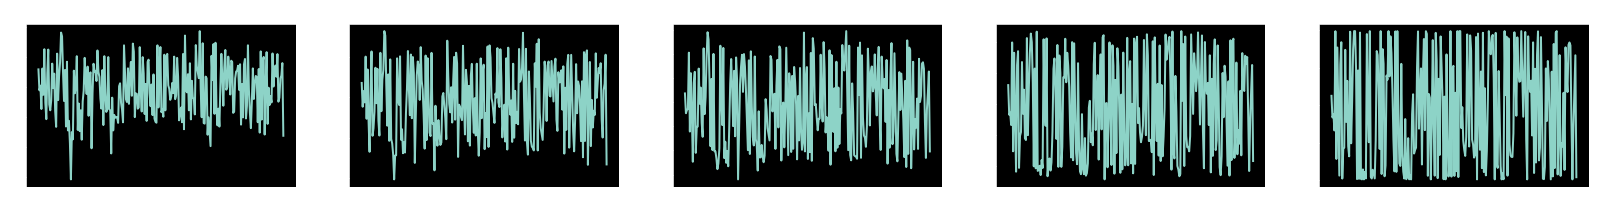

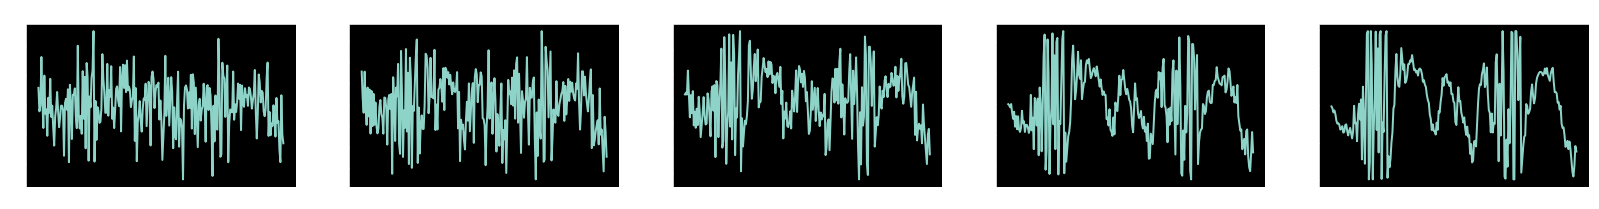

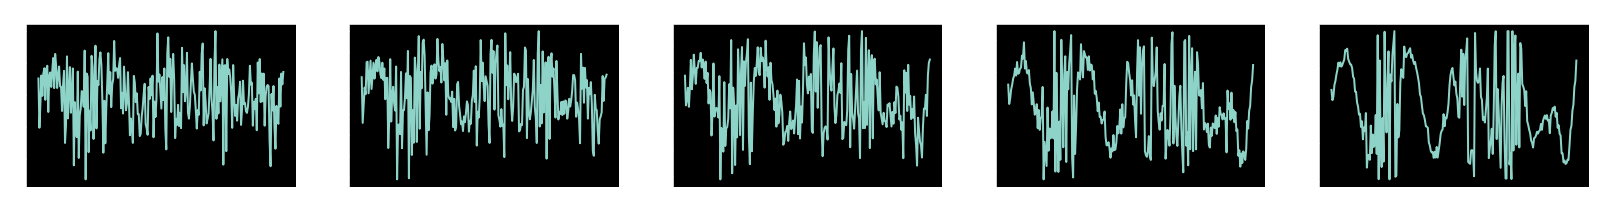

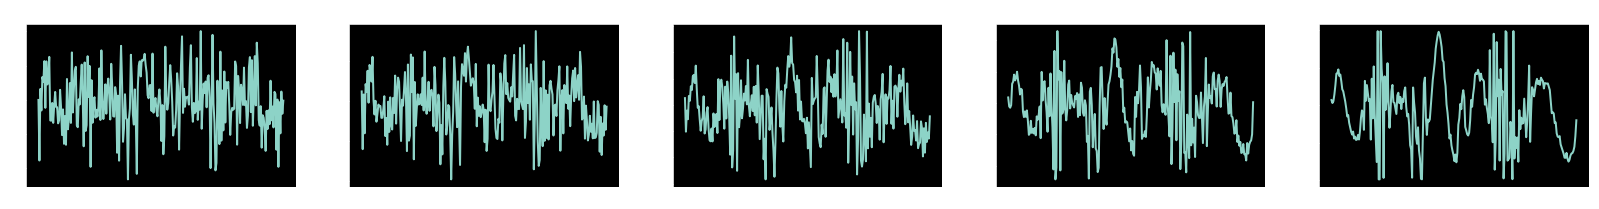

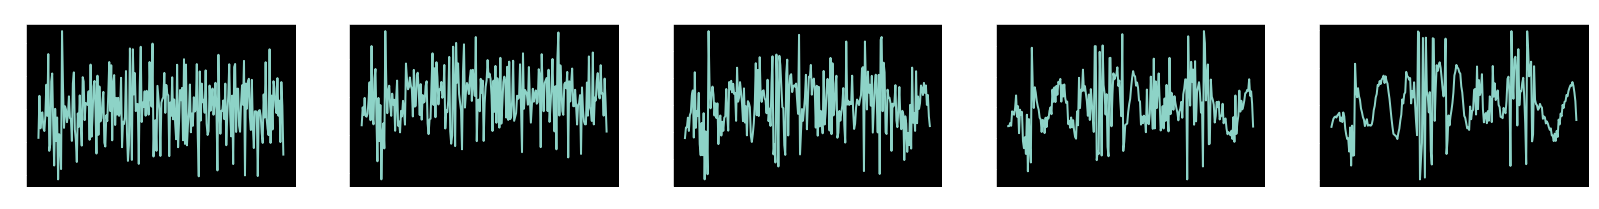

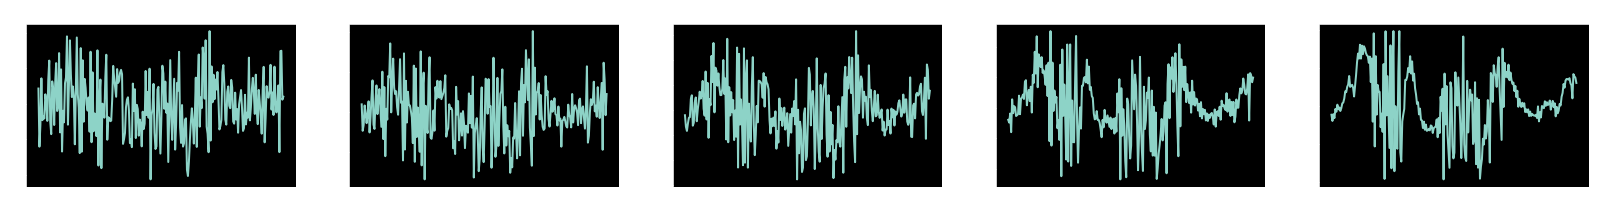

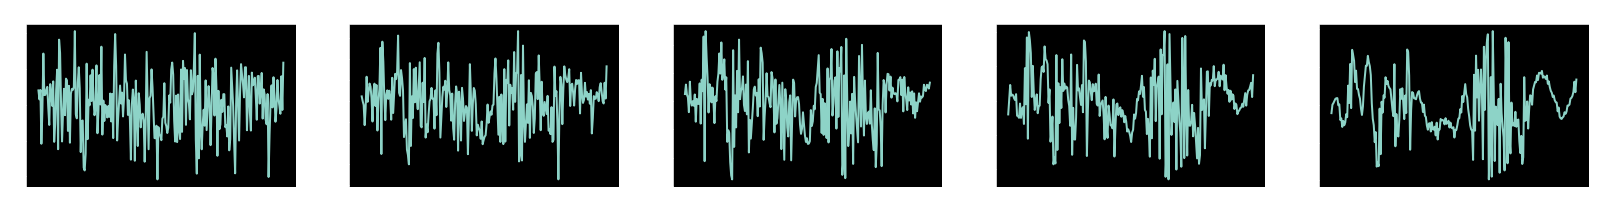

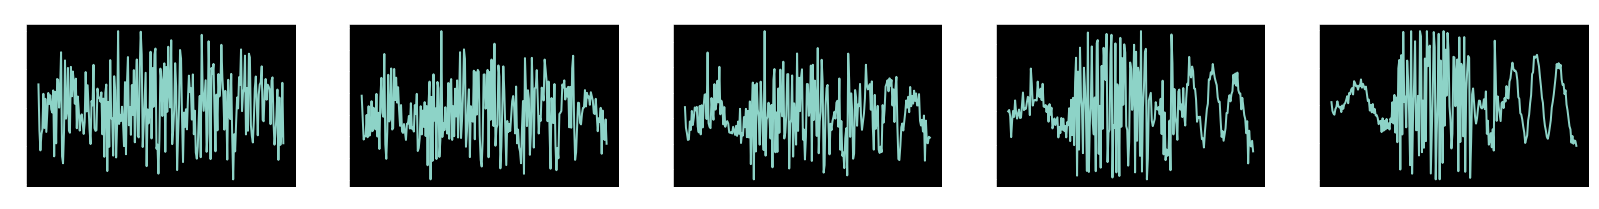

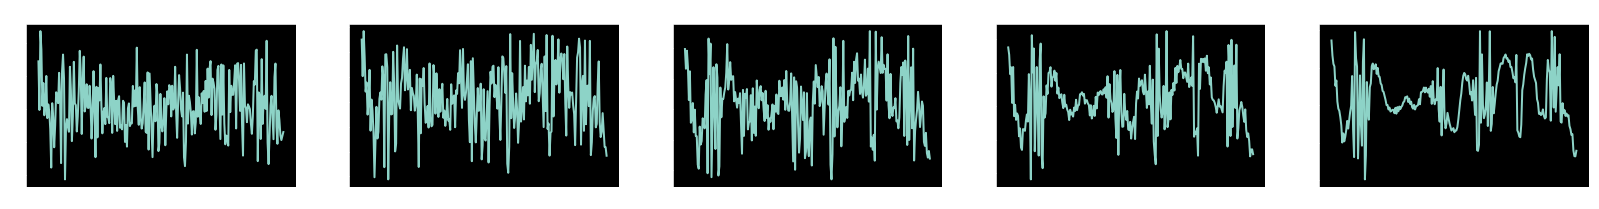

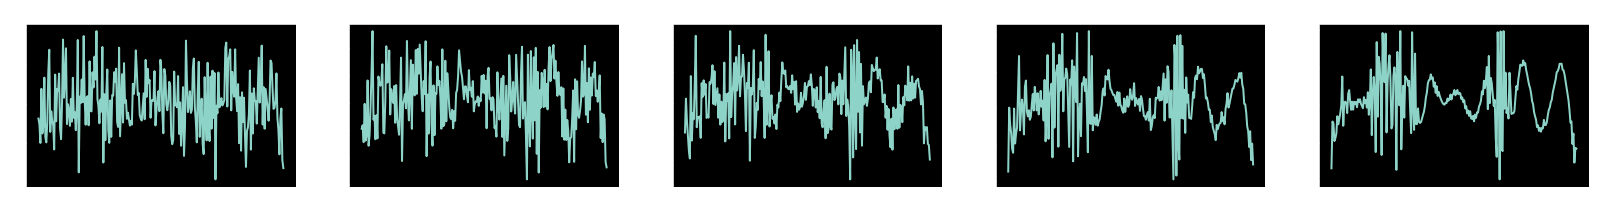

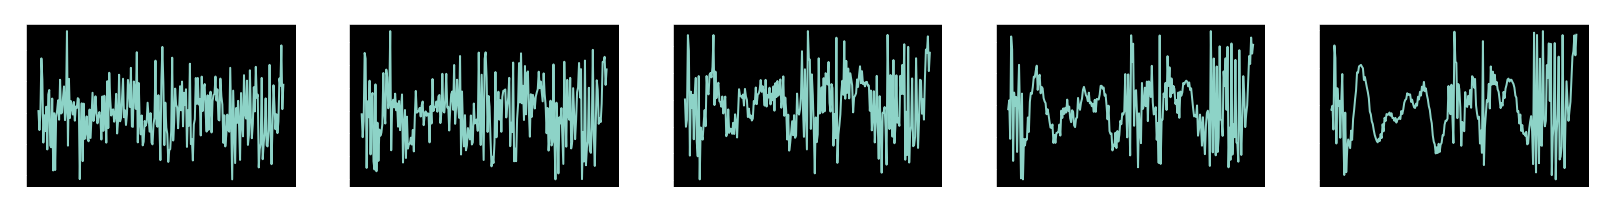

In [82]:
# Create ADAM optimizer over our model
model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Create EMA model
ema = EMA(0.9)
ema.register(model)
batch_size = 128
for t in range(2001):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch 
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = compute_loss(model, batch_x) #compute_loss(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 200 == 0):
        print(loss)
        x_seq = p_sample_loop(model, [1, dataset.shape[1]])
        fig, axs = plt.subplots(1, 5, figsize=(28, 3))
        for i in range(1, 6):
            cur_x = x_seq[i * 10 - 1].detach()
            axs[i-1].plot(cur_x[0, :], linewidth=2);
            #axs[i].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

### Advanced WaveGrad architecture

As discussed earlier, one of the major proposal in the WaveGrad paper concerns the architecture of the model. Notably, we bypassed the specific parts of
- Relying on downsampling and upsampling blocks
- Using FiLM layers to condition on Mel spectrogram

Here, we show the implementation of these blocks for defining the complete WaveGrad model, based on the implementation found in [this GitHub](https://github.com/ivanvovk/WaveGrad)

### Basic blocks 

First the WaveGrad model defines some simple blocks regarding the convolutions and modulation (with FiLM layers).

In [43]:
class Conv1dWithInitialization(nn.Module):
    def __init__(self, **kwargs):
        super(Conv1dWithInitialization, self).__init__()
        self.conv1d = torch.nn.Conv1d(**kwargs)
        torch.nn.init.orthogonal_(self.conv1d.weight.data, gain=1)

    def forward(self, x):
        return self.conv1d(x)
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation):
        super(ConvolutionBlock, self).__init__()
        self.leaky_relu = torch.nn.LeakyReLU(0.2)
        self.convolution = Conv1dWithInitialization(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=dilation,
            dilation=dilation
        )
    
    def forward(self, x):
        outputs = self.leaky_relu(x)
        outputs = self.convolution(outputs)
        return outputs
class BasicModulationBlock(nn.Module):
    """
    Linear modulation part of UBlock, represented by sequence of the following layers:
        - Feature-wise Affine
        - LReLU
        - 3x1 Conv
    """
    def __init__(self, n_channels, dilation):
        super(BasicModulationBlock, self).__init__()
        self.featurewise_affine = FeatureWiseAffine()
        self.leaky_relu = torch.nn.LeakyReLU(0.2)
        self.convolution = Conv1dWithInitialization(
            in_channels=n_channels,
            out_channels=n_channels,
            kernel_size=3,
            stride=1,
            padding=dilation,
            dilation=dilation
        )

    def forward(self, x, scale, shift):
        outputs = self.featurewise_affine(x, scale, shift)
        outputs = self.leaky_relu(outputs)
        outputs = self.convolution(outputs)
        return outputs
class InterpolationBlock(nn.Module):
    def __init__(self, scale_factor, mode='linear', align_corners=False, downsample=False):
        super(InterpolationBlock, self).__init__()
        self.mode = mode
        self.downsample = downsample
        self.scale_factor = scale_factor
        self.align_corners = align_corners
    
    def forward(self, x):
        if (self.downsample):
            size = x.shape[-1] // self.scale_factor
        else:
            size = x.shape[-1] * self.scale_factor
        outputs = torch.nn.functional.interpolate(x, 
            size = size, mode=self.mode,
            align_corners=self.align_corners,
            recompute_scale_factor=False
        )
        return outputs
class FeatureWiseLinearModulation(nn.Module):
    def __init__(self, in_channels, out_channels, input_dscaled_by):
        super(FeatureWiseLinearModulation, self).__init__()
        self.signal_conv = torch.nn.Sequential(*[
            Conv1dWithInitialization(
                in_channels=in_channels,
                out_channels=in_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            torch.nn.LeakyReLU(0.2)
        ])
        self.positional_encoding = PositionalEncoding(in_channels)
        self.scale_conv = Conv1dWithInitialization(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.shift_conv = Conv1dWithInitialization(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )

    def forward(self, x, noise_level):
        outputs = self.signal_conv(x)
        outputs = outputs + self.positional_encoding(noise_level).unsqueeze(-1)
        scale, shift = self.scale_conv(outputs), self.shift_conv(outputs)
        return scale, shift
class FeatureWiseAffine(nn.Module):
    def __init__(self):
        super(FeatureWiseAffine, self).__init__()

    def forward(self, x, scale, shift):
        outputs = scale * x + shift
        return outputs

### Upsampling and downsampling

The other major aspect of WaveGrad is that there is two reciprocal paths, one for _upsampling_ the conditioning features, and the other for _downsampling_ the 

In [83]:
class UpsamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, factor, dilations):
        super(UpsamplingBlock, self).__init__()
        self.first_block_main_branch = torch.nn.ModuleDict({
            'upsampling': torch.nn.Sequential(*[
                torch.nn.LeakyReLU(0.2),
                InterpolationBlock(
                    scale_factor=factor,
                    mode='linear',
                    align_corners=False
                ),
                Conv1dWithInitialization(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=3,
                    stride=1,
                    padding=dilations[0],
                    dilation=dilations[0]
                )
            ]),
            'modulation': BasicModulationBlock(
                out_channels, dilation=dilations[1]
            )
        })
        self.first_block_residual_branch = torch.nn.Sequential(*[
            Conv1dWithInitialization(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1
            ),
            InterpolationBlock(
                scale_factor=factor,
                mode='linear',
                align_corners=False
            )
        ])
        self.second_block_main_branch = torch.nn.ModuleDict({
            f'modulation_{idx}': BasicModulationBlock(
                out_channels, dilation=dilations[2 + idx]
            ) for idx in range(2)
        })

    def forward(self, x, scale, shift):
        # First upsampling residual block
        outputs = self.first_block_main_branch['upsampling'](x)
        outputs = self.first_block_main_branch['modulation'](outputs, scale, shift)
        outputs = outputs + self.first_block_residual_branch(x)

        # Second residual block
        residual = self.second_block_main_branch['modulation_0'](outputs, scale, shift)
        outputs = outputs + self.second_block_main_branch['modulation_1'](residual, scale, shift)
        return outputs
class DownsamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, factor, dilations):
        super(DownsamplingBlock, self).__init__()
        in_sizes = [in_channels] + [out_channels for _ in range(len(dilations) - 1)]
        out_sizes = [out_channels for _ in range(len(in_sizes))]
        self.main_branch = torch.nn.Sequential(*([
            InterpolationBlock(
                scale_factor=factor,
                mode='linear',
                align_corners=False,
                downsample=True
            )
        ] + [
            ConvolutionBlock(in_size, out_size, dilation)
            for in_size, out_size, dilation in zip(in_sizes, out_sizes, dilations)
        ]))
        self.residual_branch = torch.nn.Sequential(*[
            Conv1dWithInitialization(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1
            ),
            InterpolationBlock(
                scale_factor=factor,
                mode='linear',
                align_corners=False,
                downsample=True
            )
        ])

    def forward(self, x):
        outputs = self.main_branch(x)
        outputs = outputs + self.residual_branch(x)
        return outputs

### Final model

In [ ]:
config = nn.Module()
config.factors = [5, 5, 3, 2, 2]
config.upsampling_preconv_out_channels = 768
config.upsampling_out_channels = [512, 512, 256, 128, 128]
config.upsampling_dilations = [
            [1, 2, 1, 2],
            [1, 2, 1, 2],
            [1, 2, 4, 8],
            [1, 2, 4, 8],
            [1, 2, 4, 8]
        ]
config.downsampling_preconv_out_channels = 32
config.downsampling_out_channels = [128, 128, 256, 512]
config.downsampling_dilations = [[1, 2, 4], [1, 2, 4], [1, 2, 4], [1, 2, 4]]
config.n_mels = 80
class WaveGradNN(nn.Module):
    """
    WaveGrad is a fully-convolutional mel-spectrogram conditional
    vocoder model for waveform generation introduced in
    "WaveGrad: Estimating Gradients for Waveform Generation" paper (link: https://arxiv.org/pdf/2009.00713.pdf).
    The concept is built on the prior work on score matching and diffusion probabilistic models.
    Current implementation follows described architecture in the paper.
    """
    def __init__(self, config):
        super(WaveGradNN, self).__init__()
        # Building upsampling branch (mels -> signal)
        self.ublock_preconv = Conv1dWithInitialization(
            in_channels=config.n_mels,
            out_channels=config.upsampling_preconv_out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        upsampling_in_sizes = [config.upsampling_preconv_out_channels] \
            + config.upsampling_out_channels[:-1]
        self.ublocks = torch.nn.ModuleList([
            UpsamplingBlock(
                in_channels=in_size,
                out_channels=out_size,
                factor=factor,
                dilations=dilations
            ) for in_size, out_size, factor, dilations in zip(
                upsampling_in_sizes,
                config.upsampling_out_channels,
                config.factors,
                config.upsampling_dilations
            )
        ])
        self.ublock_postconv = Conv1dWithInitialization(
            in_channels=config.upsampling_out_channels[-1],
            out_channels=1,
            kernel_size=3,
            stride=1,
            padding=1
        )
        # Building downsampling branch (starting from signal)
        self.dblock_preconv = Conv1dWithInitialization(
            in_channels=1,
            out_channels=config.downsampling_preconv_out_channels,
            kernel_size=5,
            stride=1,
            padding=2
        )
        downsampling_in_sizes = [config.downsampling_preconv_out_channels] \
            + config.downsampling_out_channels[:-1]
        self.dblocks = torch.nn.ModuleList([
            DownsamplingBlock(
                in_channels=in_size,
                out_channels=out_size,
                factor=factor,
                dilations=dilations
            ) for in_size, out_size, factor, dilations in zip(
                downsampling_in_sizes,
                config.downsampling_out_channels,
                config.factors[1:][::-1],
                config.downsampling_dilations
            )
        ])

        # Building FiLM connections (in order of downscaling stream)
        film_in_sizes = [32] + config.downsampling_out_channels
        film_out_sizes = config.upsampling_out_channels[::-1]
        film_factors = [1] + config.factors[1:][::-1]
        self.films = torch.nn.ModuleList([
            FeatureWiseLinearModulation(
                in_channels=in_size,
                out_channels=out_size,
                input_dscaled_by=np.product(film_factors[:i+1])  # for proper positional encodings initialization
            ) for i, (in_size, out_size) in enumerate(
                zip(film_in_sizes, film_out_sizes)
            )
        ])

    def forward(self, mels, yn, noise_level):
        """
        Computes forward pass of neural network.
        :param mels (torch.Tensor): mel-spectrogram acoustic features of shape [B, n_mels, T//hop_length]
        :param yn (torch.Tensor): noised signal `y_n` of shape [B, T]
        :param noise_level (float): level of noise added by diffusion
        :return (torch.Tensor): epsilon noise
        """
        # Prepare inputs
        assert len(mels.shape) == 3  # B, n_mels, T
        yn = yn.unsqueeze(1)
        assert len(yn.shape) == 3  # B, 1, T

        # Downsampling stream + Linear Modulation statistics calculation
        statistics = []
        dblock_outputs = self.dblock_preconv(yn)
        scale, shift = self.films[0](x=dblock_outputs, noise_level=noise_level)
        statistics.append([scale, shift])
        for dblock, film in zip(self.dblocks, self.films[1:]):
            dblock_outputs = dblock(dblock_outputs)
            scale, shift = film(x=dblock_outputs, noise_level=noise_level)
            statistics.append([scale, shift])
        statistics = statistics[::-1]
        
        # Upsampling stream
        ublock_outputs = self.ublock_preconv(mels)
        for i, ublock in enumerate(self.ublocks):
            scale, shift = statistics[i]
            ublock_outputs = ublock(x=ublock_outputs, scale=scale, shift=shift)
        outputs = self.ublock_postconv(ublock_outputs)
        return outputs.squeeze(1)

## Bibliography

<a id="ref1"/>

[1] [Ho, J., Jain, A., & Abbeel, P. (2020). _Denoising diffusion probabilistic models_. arXiv preprint arXiv:2006.11239.](https://arxiv.org/pdf/2006.11239)

<a id="ref2"/>

[2] [Sohl-Dickstein, J., Weiss, E. A., Maheswaranathan, N., & Ganguli, S. (2015). Deep unsupervised learning using nonequilibrium thermodynamics. arXiv preprint arXiv:1503.03585.](https://arxiv.org/pdf/1503.03585)

<a id="ref3"/>

[3] [Vincent, P. (2011). A connection between score matching and denoising autoencoders. Neural computation, 23(7), 1661-1674.](http://www-labs.iro.umontreal.ca/~vincentp/Publications/smdae_techreport_1358.pdf)

<a id="ref4"/>

[4] [Song, J., Meng, C., & Ermon, S. (2020). Denoising Diffusion Implicit Models. arXiv preprint arXiv:2010.02502.](https://arxiv.org/pdf/2010.02502.pdf)

<a id="ref5"/>

[5] [Chen, N., Zhang, Y., Zen, H., Weiss, R. J., Norouzi, M., & Chan, W. (2020). _WaveGrad: Estimating gradients for waveform generation_. arXiv preprint arXiv:2009.00713.](https://arxiv.org/pdf/2009.00713)

<a id="ref6"/>

[6] [Hyvärinen, A. (2005). Estimation of non-normalized statistical models by score matching. Journal of Machine Learning Research, 6(Apr), 695-709.](http://jmlr.org/papers/volume6/hyvarinen05a/old.pdf)

<a id="ref7"/>

[7] [Song, Y., Garg, S., Shi, J., & Ermon, S. (2020, August). Sliced score matching: A scalable approach to density and score estimation. In Uncertainty in Artificial Intelligence (pp. 574-584). PMLR.](https://arxiv.org/pdf/1905.07088.pdf)

<a id="ref8"/>

[8] [Song, Y., & Ermon, S. (2019). Generative modeling by estimating gradients of the data distribution. In Advances in Neural Information Processing Systems (pp. 11918-11930).](https://arxiv.org/pdf/1907.05600.pdf)

### Inspiration and sources

https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/score_matching.ipynb
https://github.com/ermongroup/sliced_score_matching